In [ ]:
!pip install artemis
!pip install pyartemis
!pip install shap

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod,
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import shap

In [6]:
df = pd.read_csv(r"C:\Users\user1\Downloads\cardio_data_cleaned(IQR).csv")

In [7]:
df.head()

,age,gender,cholesterol,gluc,smoke,alco,active,cardio,BMI,MAP
0,3,2,1,1,0,0,1,0,2,2
1,4,1,3,1,0,0,1,1,3,4
2,3,1,3,1,0,0,0,1,2,2
3,2,2,1,1,0,0,1,1,3,5
4,5,1,2,2,0,0,0,0,3,2


In [8]:
df.isnull().sum()

age            0
gender         0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
BMI            0
MAP            0
dtype: int64

# Splitting and Scaling data

In [9]:
X = df.drop('cardio',axis = 1)
y = df['cardio']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Individual Models

In [12]:
n_iter = 10
cv_folds = 3

## Logistic Regression

In [13]:
param_distributions_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced']
}

In [14]:
LR = LogisticRegression()

In [15]:
random_search_lr = RandomizedSearchCV(LR, param_distributions=param_distributions_lr, n_iter=n_iter, cv=cv_folds, scoring='accuracy', random_state=42, n_jobs=-1)

In [16]:
random_search_lr.fit(X_train, y_train)
best_lr = random_search_lr.best_estimator_

C:\Users\user1\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user1\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user1\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "C:\Users\user1\AppData\Roaming\Python\Python38\site-package

In [17]:
y_pred_lr_rs = best_lr.predict(X_test)
print("Best Logistic Regression Hyperparameters:", random_search_lr.best_params_)
print('Random Search LR Accuracy:', accuracy_score(y_test, y_pred_lr_rs))
print('Random Search LR Precision:', precision_score(y_test, y_pred_lr_rs))
print('Random Search LR Recall:', recall_score(y_test, y_pred_lr_rs))
print('Random Search LR F1 Score:', f1_score(y_test, y_pred_lr_rs))

Best Logistic Regression Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'fit_intercept': True, 'class_weight': None, 'C': 78.47599703514607}
Random Search LR Accuracy: 0.7211423086153108
Random Search LR Precision: 0.7430808448652586
Random Search LR Recall: 0.6629304743339831
Random Search LR F1 Score: 0.7007211538461539


## Decision Tree

In [18]:
param_distributions_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.0, 0.1))
}

In [19]:
DT = DecisionTreeClassifier()

In [20]:
random_search_dt = RandomizedSearchCV(DT, param_distributions=param_distributions_dt, n_iter=n_iter, cv=cv_folds, scoring='accuracy', random_state=42, n_jobs=-1)

In [21]:
random_search_dt.fit(X_train, y_train)
best_dt = random_search_dt.best_estimator_

In [22]:
y_pred_dt_rs = best_dt.predict(X_test)
print("Best Decision Tree Hyperparameters:", random_search_dt.best_params_)
print('Random Search DT Accuracy:', accuracy_score(y_test, y_pred_dt_rs))
print('Random Search DT Precision:', precision_score(y_test, y_pred_dt_rs))
print('Random Search DT Recall:', recall_score(y_test, y_pred_dt_rs))
print('Random Search DT F1 Score:', f1_score(y_test, y_pred_dt_rs))

Best Decision Tree Hyperparameters: {'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_depth': 14, 'criterion': 'entropy'}
Random Search DT Accuracy: 0.722582193424526
Random Search DT Precision: 0.734965034965035
Random Search DT Recall: 0.6829109811565952
Random Search DT F1 Score: 0.7079824856854159


## Random Forest

In [23]:
param_distributions_rf = {
    'n_estimators': [int(x) for x in np.linspace(200,2000,10)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [24]:
RF = RandomForestClassifier()

In [25]:
random_search_rf = RandomizedSearchCV(RF, param_distributions=param_distributions_rf, n_iter=5, cv=cv_folds, scoring='accuracy', random_state=42, n_jobs=-1)


In [26]:
random_search_rf.fit(X_train, y_train)
best_rf = random_search_rf.best_estimator_

In [27]:
y_pred_rf_rs = best_rf.predict(X_test)
print("Best Random Forest Hyperparameters:", random_search_rf.best_params_)
print('Random Search RF Accuracy:', accuracy_score(y_test, y_pred_rf_rs))
print('Random Search RF Precision:', precision_score(y_test, y_pred_rf_rs))
print('Random Search RF Recall:', recall_score(y_test, y_pred_rf_rs))
print('Random Search RF F1 Score:', f1_score(y_test, y_pred_rf_rs))

Best Random Forest Hyperparameters: {'n_estimators': 1800, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'max_depth': 16, 'class_weight': 'balanced_subsample', 'bootstrap': True}
Random Search RF Accuracy: 0.7230621550275977
Random Search RF Precision: 0.7299419597132127
Random Search RF Recall: 0.6946068875893437
Random Search RF F1 Score: 0.7118361911103712


## SVM

In [28]:
SVM = SVC(probability = True)

In [29]:
SVM.fit(X_train[:10000], y_train[:10000])
best_svm = SVM

In [30]:
y_pred_svm_rs = best_svm.predict(X_test)
print('Random Search SVM Accuracy:', accuracy_score(y_test, y_pred_svm_rs))
print('Random Search SVM Precision:', precision_score(y_test, y_pred_svm_rs))
print('Random Search SVM Recall:', recall_score(y_test, y_pred_svm_rs))
print('Random Search SVM F1 Score:', f1_score(y_test, y_pred_svm_rs))

Random Search SVM Accuracy: 0.7190624750019998
Random Search SVM Precision: 0.7350640113798008
Random Search SVM Recall: 0.6715399610136452
Random Search SVM F1 Score: 0.701867572156197


## KNN

In [31]:
param_distributions_knn = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

In [32]:
KNN = KNeighborsClassifier()

In [33]:
random_search_knn = RandomizedSearchCV(KNN, param_distributions=param_distributions_knn, n_iter=n_iter, cv=cv_folds, scoring='accuracy', random_state=42, n_jobs=-1)

In [34]:
random_search_knn.fit(X_train, y_train)
best_knn = random_search_knn.best_estimator_


In [35]:
y_pred_knn_rs = best_knn.predict(X_test)
print("Best KNN Hyperparameters:", random_search_knn.best_params_)
print('Random Search KNN Accuracy:', accuracy_score(y_test, y_pred_knn_rs))
print('Random Search KNN Precision:', precision_score(y_test, y_pred_knn_rs))
print('Random Search KNN Recall:', recall_score(y_test, y_pred_knn_rs))
print('Random Search KNN F1 Score:', f1_score(y_test, y_pred_knn_rs))

Best KNN Hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 21, 'algorithm': 'brute'}
Random Search KNN Accuracy: 0.7083433325333973
Random Search KNN Precision: 0.7001594896331739
Random Search KNN Recall: 0.7131254061078622
Random Search KNN F1 Score: 0.7065829711894416


## XGBoost

In [36]:
param_distributions_xgb = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': range(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'objective': ['binary:logistic'],
    'random_state': [3]
}

In [37]:
XGBoost = XGBClassifier()

In [38]:
random_search_xgb = RandomizedSearchCV(XGBoost, param_distributions=param_distributions_xgb, n_iter=n_iter, cv=cv_folds, scoring='accuracy', random_state=42, n_jobs=-1)

In [39]:
random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_

In [40]:
y_pred_xgb_rs = best_xgb.predict(X_test)
print("Best XGBoost Hyperparameters:", random_search_xgb.best_params_)
print('Random Search XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb_rs))
print('Random Search XGBoost Precision:', precision_score(y_test, y_pred_xgb_rs))
print('Random Search XGBoost Recall:', recall_score(y_test, y_pred_xgb_rs))
print('Random Search XGBoost F1 Score:', f1_score(y_test, y_pred_xgb_rs))

Best XGBoost Hyperparameters: {'subsample': 0.6, 'random_state': 3, 'objective': 'binary:logistic', 'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 0.7}
Random Search XGBoost Accuracy: 0.7252219822414206
Random Search XGBoost Precision: 0.739566825145272
Random Search XGBoost Recall: 0.682261208576998
Random Search XGBoost F1 Score: 0.7097591888466414


## ROC for all classifiers

In [41]:
fpr,tpr,thresholds = roc_curve(y_test, y_pred_lr_rs)
fpr2,tpr2,thresholds2 = roc_curve(y_test, y_pred_dt_rs)
fpr3,tpr3,thresholds3 = roc_curve(y_test, y_pred_rf_rs)
fpr4,tpr4,thresholds4 = roc_curve(y_test, y_pred_svm_rs)
fpr5,tpr5,thresholds5 = roc_curve(y_test, y_pred_knn_rs)
fpr6,tpr6,thresholds6 = roc_curve(y_test, y_pred_xgb_rs)

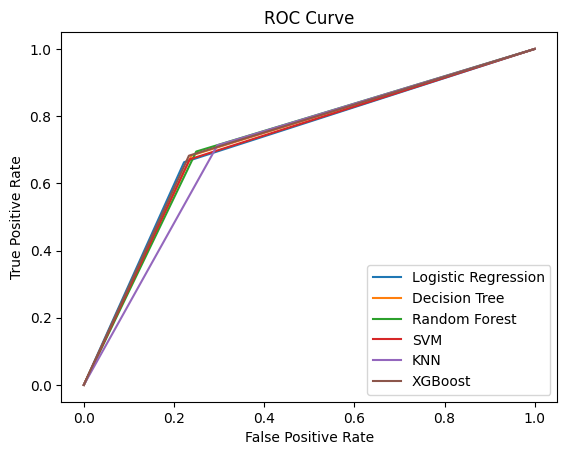

In [42]:
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Decision Tree')
plt.plot(fpr3, tpr3, label='Random Forest')
plt.plot(fpr4, tpr4, label='SVM')
plt.plot(fpr5, tpr5, label='KNN')
plt.plot(fpr6, tpr6, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Ensemble Classifier

## Stacking

In [43]:
estimators = [('SVM', best_svm), ('DT', best_dt), ('RF', best_rf)]
stacking = StackingClassifier(estimators=estimators, final_estimator=XGBoost)

In [44]:
stacking.fit(X_train[:10000], y_train[:10000])

StackingClassifier(estimators=[('SVM', SVC(probability=True)),
                               ('DT',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=14,
                                                       max_features='log2',
                                                       min_samples_leaf=15,
                                                       min_samples_split=12)),
                               ('RF',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=16,
                                                       min_samples_leaf=19,
                                                       min_samples_split=9,
                                                       n_estimators=1800))],
                   final_estimator=XGBClassifi...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [45]:
y_pred = stacking.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.6979441644668426
Precision: 0.7072448624172762
Recall: 0.6596816114359974
F1 Score: 0.6826357370986721


## Voting

In [46]:
estimators = [ ('xgb', best_xgb), ('dt', best_dt), ('rf', best_rf), ('knn', best_knn), ('lr', best_lr)]

### Hard Voting

In [47]:
voting_hard = VotingClassifier(estimators=estimators, voting='hard')

In [48]:
voting_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=14,
                                                     max_features='log2',
                                                     min_samples_leaf=15,
                                                     min_samples_split=12)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=16,
                                                     min_samples_leaf=19,
                                                     min_samples_split=9,
                                                     n_estimators=1800)),
                             ('knn',
                              KNeighborsClassifier(algorithm='brute',
                                                   n_neighbors=21)),
                             ('lr',
                              LogisticRegression(C=78.47599703514607,
                                                 solver='newton-cg'))])

In [49]:
y_pred_hard = voting_hard.predict(X_test)
print('Hard Voting Accuracy:', accuracy_score(y_test, y_pred_hard))
print('Hard Voting Precision:', precision_score(y_test, y_pred_hard))
print('Hard Voting Recall:', recall_score(y_test, y_pred_hard))
print('Hard Voting F1 Score:', f1_score(y_test, y_pred_hard))

Hard Voting Accuracy: 0.7254619630429565
Hard Voting Precision: 0.7367049009384776
Hard Voting Recall: 0.6885964912280702
Hard Voting F1 Score: 0.71183879093199


### Soft Voting

In [50]:
voting_soft = VotingClassifier(estimators=estimators, voting='soft')

In [51]:
voting_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                                                     max_depth=14,
                                                     max_features='log2',
                                                     min_samples_leaf=15,
                                                     min_samples_split=12)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=16,
                                                     min_samples_leaf=19,
                                                     min_samples_split=9,
                                                     n_estimators=1800)),
                             ('knn',
                              KNeighborsClassifier(algorithm='brute',
                                                   n_neighbors=21)),
                             ('lr',
                              LogisticRegression(C=78.47599703514607,
                                                 solver='newton-cg'))],
                 voting='soft')

In [52]:
y_pred_soft = voting_soft.predict(X_test)
print('Soft Voting Accuracy:', accuracy_score(y_test, y_pred_soft))
print('Soft Voting Precision:', precision_score(y_test, y_pred_soft))
print('Soft Voting Recall:', recall_score(y_test, y_pred_soft))
print('Soft Voting F1 Score:', f1_score(y_test, y_pred_soft))

Soft Voting Accuracy: 0.724502039836813
Soft Voting Precision: 0.7327497425334707
Soft Voting Recall: 0.6934697855750487
Soft Voting F1 Score: 0.7125688532799199


### Bagging

In [53]:
bagging_xgb = BaggingClassifier(estimator=XGBClassifier(), n_estimators=10, random_state=42)

In [54]:
bagging_xgb.fit(X_train, y_train)

BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                  random_state=42)

In [55]:
y_pred_bagging = bagging_xgb.predict(X_test)
print('Bagging (XGBoost) Accuracy:', accuracy_score(y_test, y_pred_bagging))
print('Bagging (XGBoost) Precision:', precision_score(y_test, y_pred_bagging))
print('Bagging (XGBoost) Recall:', recall_score(y_test, y_pred_bagging))
print('Bagging (XGBoost) F1 Score:', f1_score(y_test, y_pred_bagging))

Bagging (XGBoost) Accuracy: 0.7199424046076314
Bagging (XGBoost) Precision: 0.7316349677194207
Bagging (XGBoost) Recall: 0.6811241065627031
Bagging (XGBoost) F1 Score: 0.7054765710439976


### Hybrid

In [60]:
estimators_hybrid = [('stacking', stacking), ('bagging_xgb', bagging_xgb)]
hybrid_voting = VotingClassifier(estimators=estimators_hybrid, voting='soft')

In [61]:
hybrid_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('stacking',
                              StackingClassifier(estimators=[('SVM',
                                                              SVC(probability=True)),
                                                             ('DT',
                                                              DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=14,
                                                                                     max_features='log2',
                                                                                     min_samples_leaf=15,
                                                                                     min_samples_split=12)),
                                                             ('RF',
                                                              RandomForestClassifier(class_weight='balanced_subsample',
                                                                                     max_depth=16,
                                                                                     min_samples_leaf=19,
                                                                                     min_samples_split=9,
                                                                                     n_estim...
                                                                        importance_type=None,
                                                                        interaction_constraints=None,
                                                                        learning_rate=None,
                                                                        max_bin=None,
                                                                        max_cat_threshold=None,
                                                                        max_cat_to_onehot=None,
                                                                        max_delta_step=None,
                                                                        max_depth=None,
                                                                        max_leaves=None,
                                                                        min_child_weight=None,
                                                                        missing=nan,
                                                                        monotone_constraints=None,
                                                                        multi_strategy=None,
                                                                        n_estimators=None,
                                                                        n_jobs=None,
                                                                        num_parallel_tree=None,
                                                                        random_state=None, ...),
                                                random_state=42))],
                 voting='soft')

In [62]:
y_pred_hybrid = hybrid_voting.predict(X_test)
print('Hybrid Ensemble (Voting of Stacking and Bagging) Accuracy:', accuracy_score(y_test, y_pred_hybrid))
print('Hybrid Ensemble (Voting of Stacking and Bagging) Precision:', precision_score(y_test, y_pred_hybrid))
print('Hybrid Ensemble (Voting of Stacking and Bagging) Recall:', recall_score(y_test, y_pred_hybrid))
print('Hybrid Ensemble (Voting of Stacking and Bagging) F1 Score:', f1_score(y_test, y_pred_hybrid))

Hybrid Ensemble (Voting of Stacking and Bagging) Accuracy: 0.7221022318214543
Hybrid Ensemble (Voting of Stacking and Bagging) Precision: 0.7222406363937687
Hybrid Ensemble (Voting of Stacking and Bagging) Recall: 0.7079272254710851
Hybrid Ensemble (Voting of Stacking and Bagging) F1 Score: 0.7150123051681707


In [71]:
columns = df.columns.drop('cardio')

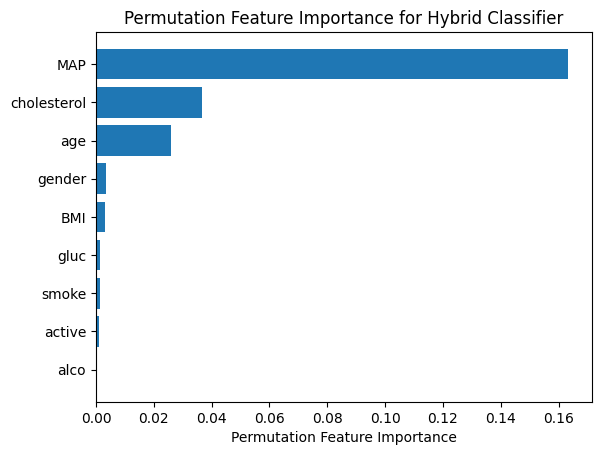

In [83]:
perm_importance = permutation_importance(hybrid_voting, X_test, y_test, n_repeats=5, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Feature Importance")
plt.title("Permutation Feature Importance for Hybrid Classifier")
plt.show()

X has feature names, but SVC was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but BaggingClassifier was fitted without feature names
ExactExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]X has feature names, but SVC was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but BaggingClassifier was fitted without feature names
X has feature names, but SVC was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but BaggingClassifier was fitted without feature names
ExactExplainer explainer:  30%|███  

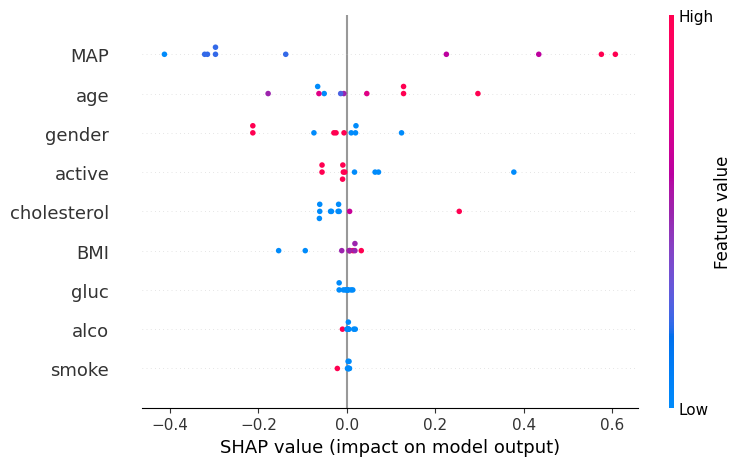

In [ ]:
explainer = shap.Explainer(hybrid_voting.predict, X_test[:10000]) 
shap_values = explainer(X_test[:10])
shap.plots.beeswarm(shap_values)


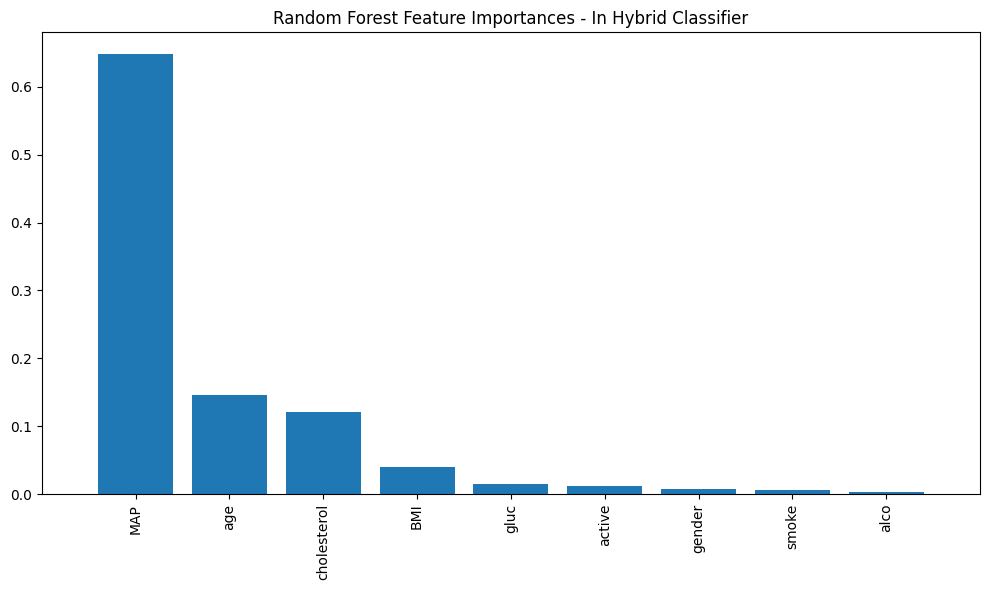

In [ ]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances - In Hybrid Classifier")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Decision Tree Feature Importances - In Hybrid Classifier")
plt.bar(range(X.shape[1]), importances[indices], align="center")


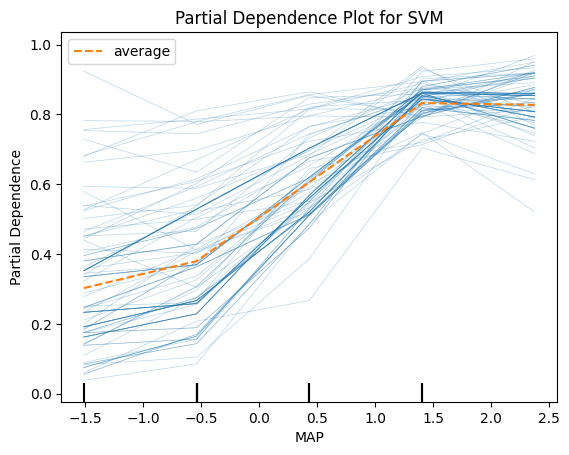

In [ ]:

features = [8]
PartialDependenceDisplay.from_estimator(hybrid_voting, X_train, features, kind="both", subsample=100, n_jobs=-1, feature_names=X.columns)
plt.title("Partial Dependence Plot for SVM")
plt.xlabel("MAP")
plt.ylabel("Partial Dependence")
plt.show() 
